In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMClassifier

Basic sorting of the data. We drop Ipswich since their first and only year was 24/25. We also drop the 14/15 season as this was only needed for building our stats, and should not be present in the dataset.

In [5]:
# load data

df = pd.read_csv("data_1.csv")

# drop first column, team names now that hayden processed the data

df = df.iloc[:, 1:]
df.head()
print(len(df))
df = df[(df['HomeTeam'] != 'Ipswich') & (df['AwayTeam'] != 'Ipswich')]
print(len(df))
df = df.drop(columns=['HomeTeam', 'AwayTeam'])

df['FTR'] = df['FTR'].replace('D', 'A')
# then label encode results
label_encoder = LabelEncoder()
df['FTR'] = label_encoder.fit_transform(df['FTR'])
# df['HTR'] = label_encoder.fit_transform(df['HTR'])

df = df[(df['Date'] >= '2015-07-01')]
print(len(df))
# then split 2024-2025 season
df_pastSeasons = df[(df['Date'] < '2023-07-01')]
df_currentSeason = df[df['Date'] >= '2023-07-01']

print('Train%', len(df_pastSeasons) / (len(df_currentSeason) + len(df_pastSeasons)))
print('Test%', len(df_currentSeason) / (len(df_pastSeasons) + len(df_currentSeason)))
# then remove dates from both datasets
df_pastSeasons = df_pastSeasons.drop(columns=['Date'])
df_currentSeason = df_currentSeason.drop(columns=['Date'])

#save
# df_pastSeasons.to_csv("Binary_Training_HTR.csv", index=False)
# df_currentSeason.to_csv("Binary_Testing_HTR.csv", index=False)



# df_pastSeasons['FTR'] = label_encoder.fit_transform(df_pastSeasons['FTR'])
# df_currentSeason['FTR'] = label_encoder.fit_transform(df_currentSeason['FTR'])
for name, index in enumerate(label_encoder.classes_):
    print(name, index)
# print('Overall Home Team wins', df['FTR'].value_counts()[2] / len(df))
# print('Overall Away Team wins', df['FTR'].value_counts()[0] / len(df))
# print('Overall Draw', df['FTR'].value_counts()[1] / len(df))
# print('Overall Home Team Wins', df['FTR'].value_counts()[1] / len(df))
# print('Overall Home Team Non-Wins', df['FTR'].value_counts()[0] / len(df))
# training
X_train = df_pastSeasons.drop(columns=['FTR'])
y_train = df_pastSeasons['FTR']
X_test = df_currentSeason.drop(columns=['FTR'])
y_test = df_currentSeason['FTR']
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['FTR', 'Date'], axis=1), df['FTR'], test_size = 0.2, random_state = 42)
print(np.unique(y_train))
print('Train%', len(y_train) / (len(y_test) + len(y_train)))
print('Test%', len(y_test) / (len(y_test) + len(y_train)))

# df.head()


4071
4044
3664
Train% 0.8296943231441049
Test% 0.1703056768558952
0 A
1 H
[0 1]
Train% 0.8296943231441049
Test% 0.1703056768558952


In [6]:
# minmax works better so stick with that
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Function to print out relevant stats and confusion matrix
def print_cm(y_test, this_y_pred, method, Encoder=False, class_report = False):
  if class_report:
    print(classification_report(y_test, this_y_pred))
  print("Accuracy:", accuracy_score(y_test, this_y_pred))
  print("Precision:", precision_score(y_test, this_y_pred, average=method))
  print("Recall:", recall_score(y_test, this_y_pred, average=method))
  print("F1 Score:", f1_score(y_test, this_y_pred, average=method))

  confusion = confusion_matrix(y_test, this_y_pred)
  sns.heatmap(confusion,
              annot=True,
              fmt='d',
              xticklabels = [class_name for class_name in Encoder.classes_ if Encoder],
              yticklabels = [class_name for class_name in Encoder.classes_ if Encoder]
              )
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [8]:
# First we start with a grid search
# I like to check accuracy scored and F1 macro scored
svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", svm_grid.best_params_)
print("Best Score Accuracy:", svm_grid.best_score_)


svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise')
svm_grid.fit(X_train, y_train)

print("Best Parameters F1:", svm_grid.best_params_)
print("Best Score F1:", svm_grid.best_score_)


Best Parameters Accuracy: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score Accuracy: 0.6546052631578948
Best Parameters F1: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score F1: 0.6377530544003763


Accuracy: 0.6539473684210526
Precision: 0.6528838320476589
Recall: 0.63870765592514
F1 Score: 0.6375819273269083


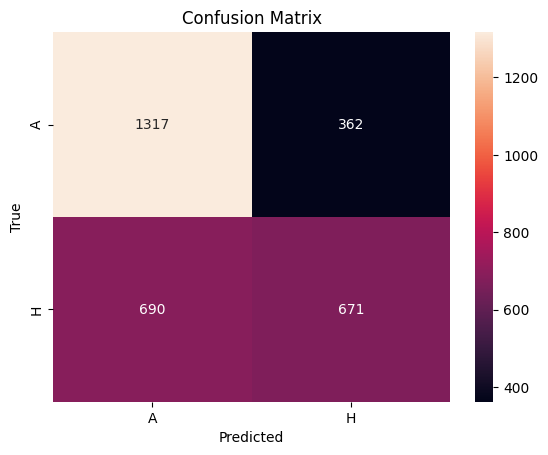

              precision    recall  f1-score   support

           0       0.68      0.74      0.71       350
           1       0.63      0.55      0.59       274

    accuracy                           0.66       624
   macro avg       0.65      0.65      0.65       624
weighted avg       0.66      0.66      0.66       624

Accuracy: 0.6602564102564102
Precision: 0.654363722902514
Recall: 0.6488008342022941
F1 Score: 0.6497649002414538


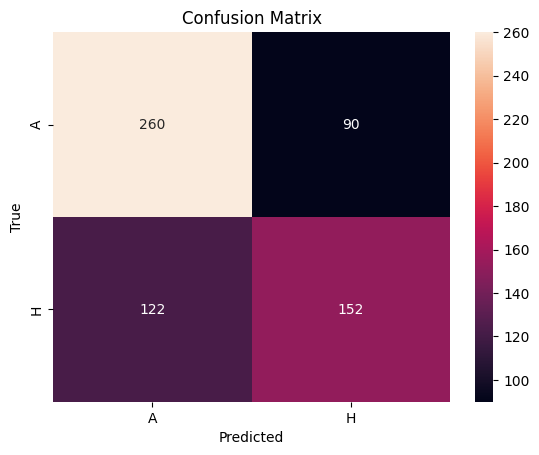

In [9]:
# SVM with Accuracy scored parameters
svm_model = SVC(kernel='linear', C=0.1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
print_cm(y_train, svm_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, svm_y_pred, 'macro', Encoder=label_encoder, class_report=True)

# svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
# svm_model.fit(X_train, y_train)
# svm_y_pred = svm_model.predict(X_test)

The SVM accuracy above is already pretty good relative to the literature, but we can keep trying for better.

In [10]:
rf_params = {
    'n_estimators': [10, 100, 500],
    'max_depth': [None, 10, 50],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", rf_grid.best_params_)
print("Best Score Accuracy:", rf_grid.best_score_)


rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Parameters F1:", rf_grid.best_params_)
print("Best Score F1:", rf_grid.best_score_)

Best Parameters Accuracy: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best Score Accuracy: 0.6546052631578948
Best Parameters F1: {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Best Score F1: 0.6381687573035612


Accuracy: 0.9032894736842105
Precision: 0.9064067916247812
Recall: 0.8986013419870038
F1 Score: 0.9013892621803724


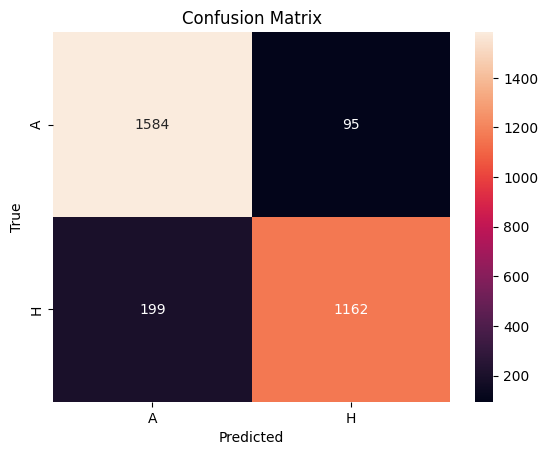

Accuracy: 0.655448717948718
Precision: 0.6494455892454126
Recall: 0.6429301355578727
F1 Score: 0.6437665789536573


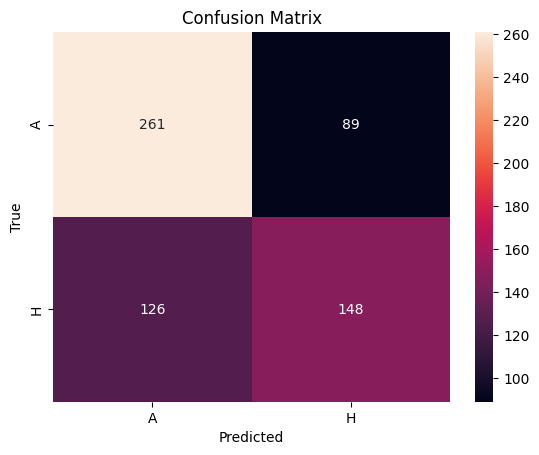

Accuracy: 0.9095394736842105
Precision: 0.9115411931818181
Recall: 0.9057206648756586
F1 Score: 0.9079538346641675


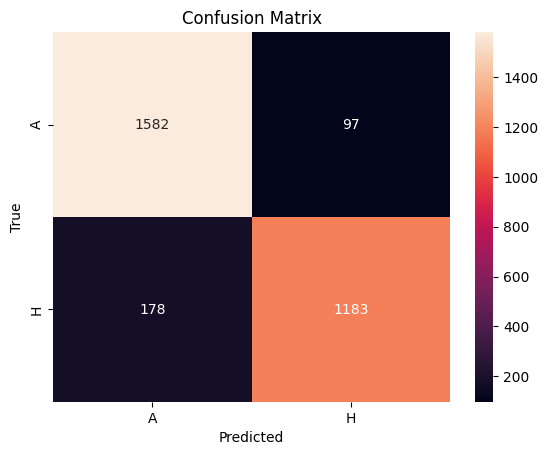

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       350
           1       0.65      0.55      0.59       274

    accuracy                           0.67       624
   macro avg       0.67      0.66      0.66       624
weighted avg       0.67      0.67      0.67       624

Accuracy: 0.6714743589743589
Precision: 0.6669145104259608
Recall: 0.6580083420229406
F1 Score: 0.6590754634009834


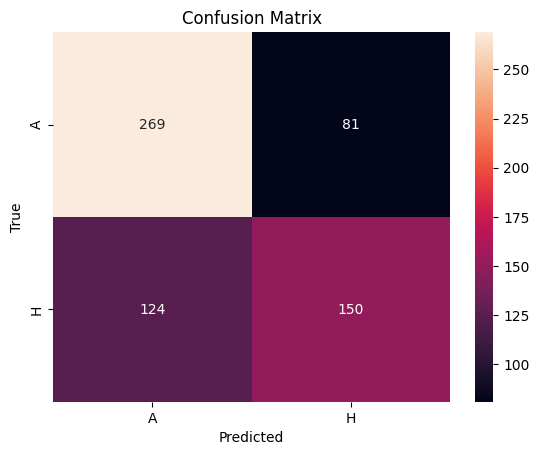

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth= None, random_state=42, min_samples_leaf=5, min_samples_split=10)
# rf_model = rf_grid.best_estimator_
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print_cm(y_train, rf_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, rf_y_pred, 'macro', Encoder=label_encoder)

rf_model = RandomForestClassifier(n_estimators=500, max_depth= 50, random_state=42, min_samples_leaf=5, min_samples_split=10)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print_cm(y_train, rf_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, rf_y_pred, 'macro', Encoder=label_encoder, class_report=True)

The random forest models above are performing alright, however the overfitting is concerning so try more models.

Next we try logistic regression. It is nice and lightweight for our dataset and generally performs well.

In [11]:
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
    }

lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", lr_grid.best_params_)
print("Best Score Accuracy:", lr_grid.best_score_)


lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise')
lr_grid.fit(X_train, y_train)

print("Best Parameters F1:", lr_grid.best_params_)
print("Best Score F1:", lr_grid.best_score_)

Best Parameters Accuracy: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score Accuracy: 0.6542763157894738
Best Parameters F1: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score F1: 0.6393643857187818


Accuracy: 0.6569078947368421
Precision: 0.6552429835535524
Recall: 0.6427098544977308
F1 Score: 0.6421677184208261


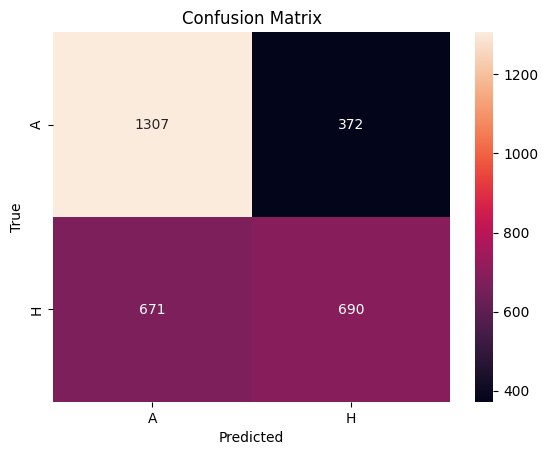

              precision    recall  f1-score   support

           0       0.68      0.74      0.71       350
           1       0.63      0.55      0.59       274

    accuracy                           0.66       624
   macro avg       0.65      0.65      0.65       624
weighted avg       0.66      0.66      0.66       624

Accuracy: 0.6602564102564102
Precision: 0.654363722902514
Recall: 0.6488008342022941
F1 Score: 0.6497649002414538


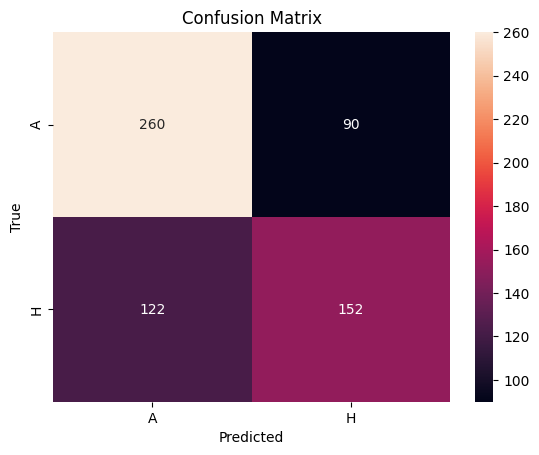

In [17]:
lr_model = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs')
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
print_cm(y_train, lr_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, lr_y_pred, 'macro', Encoder=label_encoder, class_report=True)

Now we try some naive bayes. This doesn't perform nicely but it is super fast and could yield some different results from other models.

In [ ]:

nb_params = {
    'var_smoothing': [1e-15, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
}

nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", nb_grid.best_params_)
print("Best Score Accuracy:", nb_grid.best_score_)

nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='f1_macro', n_jobs=-1)
nb_grid.fit(X_train, y_train)

print("Best Parameters F1:", nb_grid.best_params_)
print("Best Score F1:", nb_grid.best_score_)


Best Parameters Accuracy: {'var_smoothing': 1e-15}
Best Score Accuracy: 0.6342488851160816
Best Parameters F1: {'var_smoothing': 1e-15}
Best Score F1: 0.6263022447844223


Accuracy: 0.6338815789473684
Precision: 0.6289372728496433
Recall: 0.6274305626971725
F1 Score: 0.6278505396767713


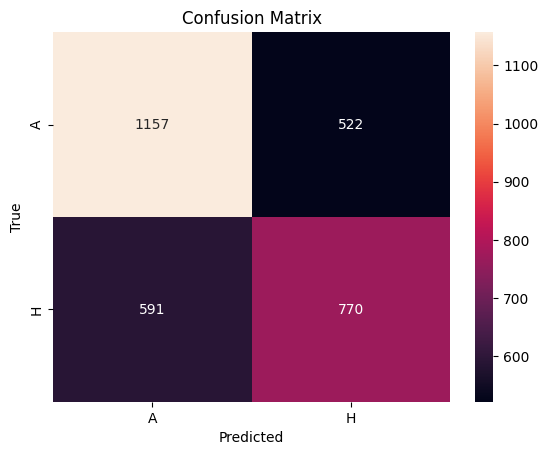

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       350
           1       0.58      0.60      0.59       274

    accuracy                           0.63       624
   macro avg       0.63      0.63      0.63       624
weighted avg       0.64      0.63      0.64       624

Accuracy: 0.6346153846153846
Precision: 0.6301988400994201
Recall: 0.6310948905109489
F1 Score: 0.630481533426835


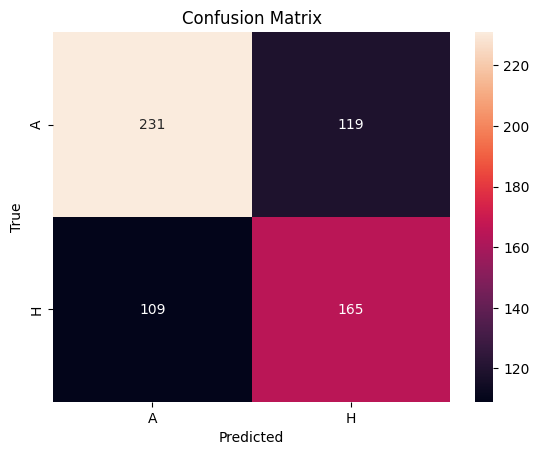

In [ ]:
nb_model = GaussianNB(var_smoothing=1e-15)
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)

print_cm(y_train, nb_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, nb_y_pred, 'macro', Encoder=label_encoder, class_report=True)

Although the naive bayes model doesn't perform as well accuracy wise, it does seems to have a better f1 for class 1 than some other models which is nice because it could help in an ensemble

Accuracy: 0.6740131578947368
Precision: 0.6732666636482316
Recall: 0.660769745470586
F1 Score: 0.6610278956858311


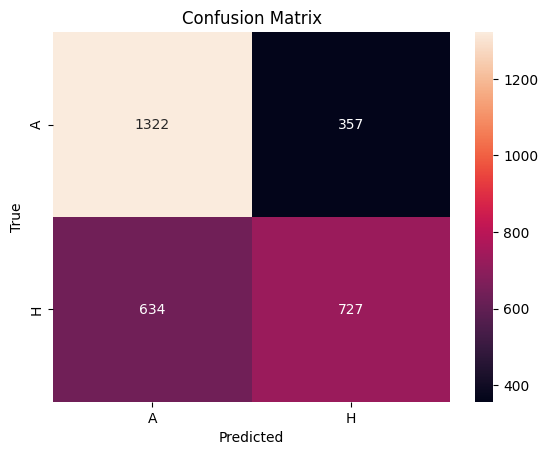

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       350
           1       0.63      0.57      0.60       274

    accuracy                           0.66       624
   macro avg       0.66      0.65      0.65       624
weighted avg       0.66      0.66      0.66       624

Accuracy: 0.6634615384615384
Precision: 0.6576332429990968
Recall: 0.6528467153284672
F1 Score: 0.6538461538461539


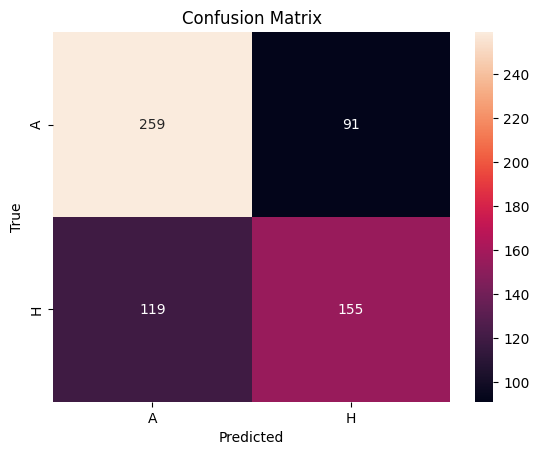

In [ ]:
# Hard voting
# these hyper paramters are a result of tuning
svm = SVC(kernel='linear', C=1, gamma='scale', random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth= 10, random_state=42, min_samples_leaf=2, min_samples_split=5)
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs')
nb = GaussianNB(var_smoothing=1e-15)

# seems to perform much better with either RF or NB taken out
voting_classifier = VotingClassifier(estimators=[('svm', svm), ('rf', rf), ('lr', lr)], voting='hard')
voting_classifier.fit(X_train, y_train)
print_cm(y_train, voting_classifier.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, voting_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

The hard voting above looks pretty good. One of the leaders so far.

Accuracy: 0.6578947368421053
Precision: 0.6553722757663605
Recall: 0.6449252752263668
F1 Score: 0.6448788009627451


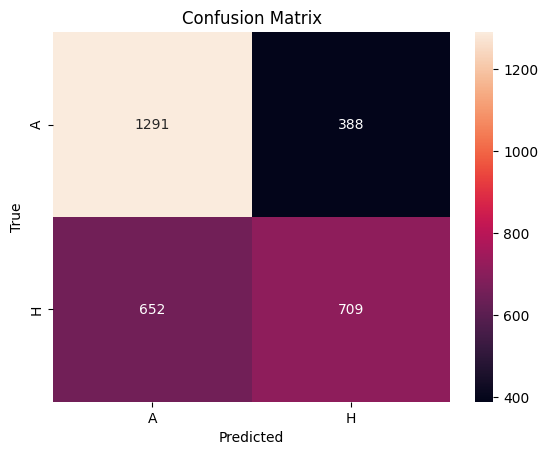

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       350
           1       0.63      0.57      0.60       274

    accuracy                           0.66       624
   macro avg       0.66      0.65      0.65       624
weighted avg       0.66      0.66      0.66       624

Accuracy: 0.6618589743589743
Precision: 0.6559196787148595
Recall: 0.6518143899895725
F1 Score: 0.6527619173204985


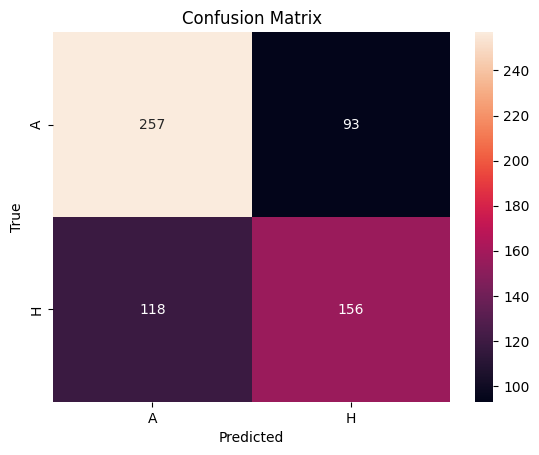

In [ ]:
# Soft voting
# As with above, the RF model has been changed slightly to try and reduce some overfitting
svm = SVC(probability=True, kernel='linear', C=1, gamma='scale', random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth= 10, random_state=42, min_samples_leaf=2, min_samples_split=5)
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs')
nb = GaussianNB(var_smoothing=1e-15)

# Without RF: the f1 for class 1 (home win) is a bit better
# Without NB: the f1 for class 1 drops 1% but overall scores go up
voting_classifier = VotingClassifier(estimators=[('svm', svm), ('lr', lr)], voting='soft')
voting_classifier.fit(X_train, y_train)
print_cm(y_train, voting_classifier.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, voting_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

The soft voting looks really good too, pretty much on par with the SVM.

Next we setup the stacking classifier. The next cell was run accidentally but the output is saved in the comments.

In [ ]:
# Stacking model
# DONT RUN THIS CELL IT TAKES ABOUT 25 MINUTES
# OUTPUT IF IT ACCIDENTALLY GETS DELETED:
# Best Parameters Accuracy: {'final_estimator__C': 10, 'final_estimator__gamma': 'scale', 'final_estimator__kernel': 'rbf'}
# Best Score Accuracy: 0.6536987400503514
# Best Parameters F1: {'final_estimator__C': 0.1, 'final_estimator__gamma': 'scale', 'final_estimator__kernel': 'linear'}
# Best Score F1: 0.6386822760945473

classifiers = [
    ('svm', SVC(probability=True, kernel='linear', C=10, gamma='scale', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42)),
    ('lr', LogisticRegression(C=10, penalty='l2', solver='lbfgs')),
    # ('gbm', GradientBoostingClassifier(n_estimators=150, learning_rate = 0.05, max_depth = 3, min_samples_leaf=3, min_samples_split=5, random_state=42))
    ('nb', GaussianNB(var_smoothing=1e-15))
]

stacking_svm_params = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__kernel': ['linear', 'rbf'],
    'final_estimator__gamma': ['scale', 'auto']
}
# meta_classifier = LogisticRegression(C=1, penalty='l2', solver='lbfgs')
meta_classifier = SVC()
# meta_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42)

stacking_classifier = StackingClassifier(estimators=classifiers, final_estimator=meta_classifier)

stacking_grid = GridSearchCV(stacking_classifier, stacking_svm_params, cv=5, scoring='accuracy', n_jobs=-1)
stacking_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", stacking_grid.best_params_)
print("Best Score Accuracy:", stacking_grid.best_score_)

stacking_grid = GridSearchCV(stacking_classifier, stacking_svm_params, cv=5, scoring='f1_macro', n_jobs=-1)
stacking_grid.fit(X_train, y_train)

print("Best Parameters F1:", stacking_grid.best_params_)
print("Best Score F1:", stacking_grid.best_score_)
# stacking_classifier.fit(X_train, y_train)


KeyboardInterrupt: 

Accuracy: 0.6720394736842106
Precision: 0.6738060595686408
Recall: 0.6564084846347171
F1 Score: 0.6556612899909123


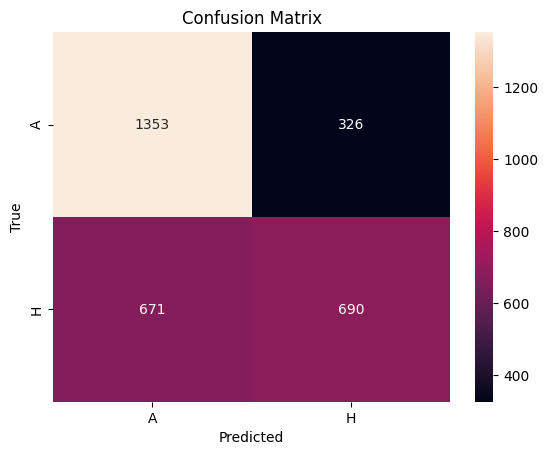

              precision    recall  f1-score   support

           0       0.66      0.76      0.71       350
           1       0.62      0.51      0.56       274

    accuracy                           0.65       624
   macro avg       0.64      0.63      0.63       624
weighted avg       0.64      0.65      0.64       624

Accuracy: 0.6474358974358975
Precision: 0.6415178571428571
Recall: 0.6322210636079248
F1 Score: 0.6324497991967871


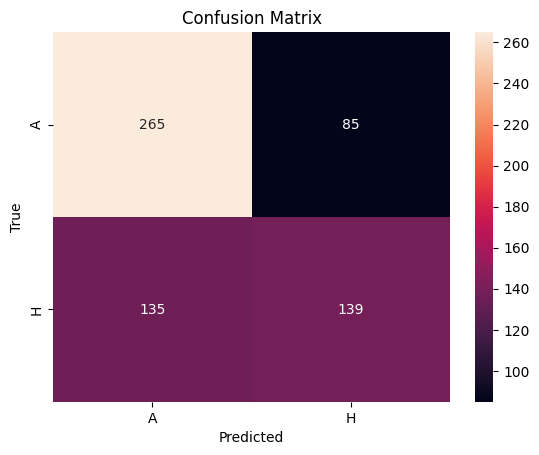

In [ ]:
meta_classifier = SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)
stacking_classifier = StackingClassifier(estimators=classifiers, final_estimator=meta_classifier)
stacking_classifier.fit(X_train, y_train)
print_cm(y_train, stacking_classifier.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, stacking_classifier.predict(X_test), 'macro', Encoder=label_encoder,class_report=True)

Stacking performs quite poorly regardless of which combination of models is used. In perticular it really struggles with the recall of class 1 which causes all the other stats to drop quite a bit.

This is the tuned version which has a very different result.

Accuracy: 0.6536184210526316
Precision: 0.6490379362290182
Recall: 0.6456462442437352
F1 Score: 0.6463097434863934


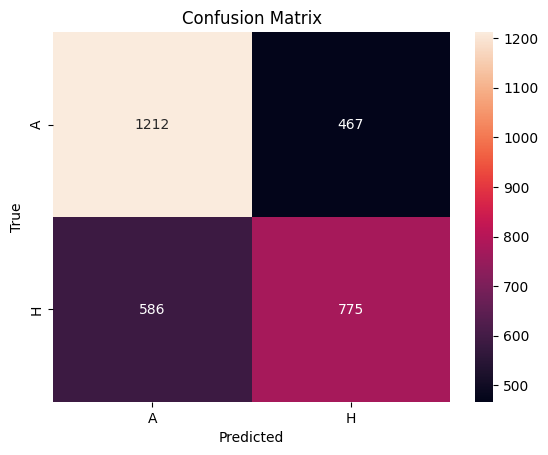

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       350
           1       0.58      0.60      0.59       274

    accuracy                           0.64       624
   macro avg       0.63      0.63      0.63       624
weighted avg       0.64      0.64      0.64       624

Accuracy: 0.6362179487179487
Precision: 0.6314650923918118
Recall: 0.6321272158498437
F1 Score: 0.6317148317148317


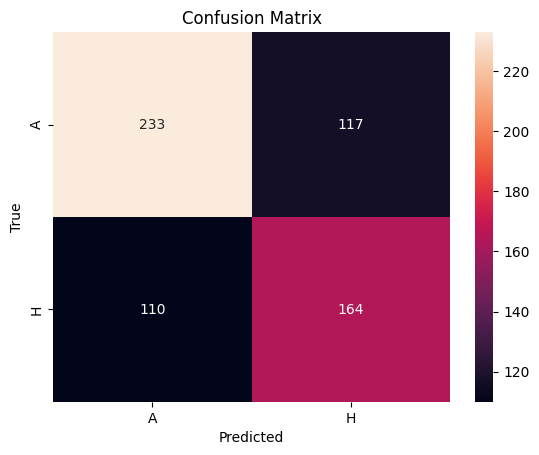

In [ ]:
# This looks better in my opinion
meta_classifier = SVC(probability=True, kernel='linear', C=0.1, gamma='scale', random_state=42)
stacking_classifier = StackingClassifier(estimators=classifiers, final_estimator=meta_classifier)
stacking_classifier.fit(X_train, y_train)
print_cm(y_train, stacking_classifier.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, stacking_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

This stacking classifier looks completely different. It has a much better f1 score for class 1 but lower for class 0

Now we just try out some KNN to see what it looks like.

Best parameters: {'metric': 'manhattan', 'n_neighbors': np.int64(20), 'weights': 'distance'}
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


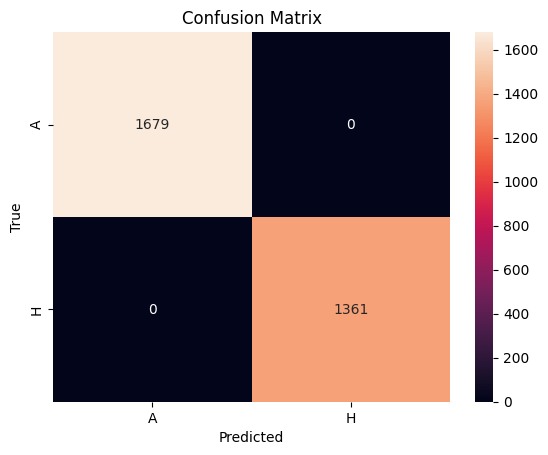

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       350
           1       0.61      0.53      0.57       274

    accuracy                           0.65       624
   macro avg       0.64      0.63      0.63       624
weighted avg       0.64      0.65      0.64       624

Accuracy: 0.6458333333333334
Precision: 0.6392878630421703
Recall: 0.6327737226277372
F1 Score: 0.6333812750730425


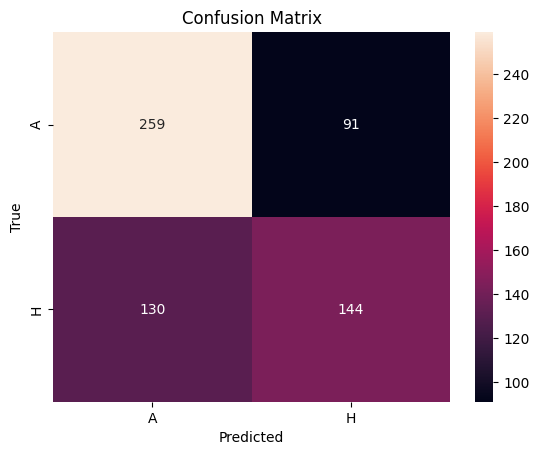

In [ ]:
KNN_param_grid = {
    'n_neighbors': np.arange(1, 30),  # Testing k values from 1 to 29
    'weights': ['uniform', 'distance'],  # Uniform gives equal weight, distance gives closer points more weight
    'metric': ['euclidean', 'manhattan']  # Different distance metrics
}

grid_search = GridSearchCV(KNeighborsClassifier(), KNN_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_knn = grid_search.best_estimator_

print_cm(y_train, best_knn.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, best_knn.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

Overfits but decent test accuracy.